# DCGAN Tutorial

A playground build on top of official PyTorch tutorial taken from [this page](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

In [1]:
%matplotlib inline

In [2]:
import os
from multiprocessing import cpu_count
from pathlib import Path
import random

In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as datautil
import torchvision.datasets as dset
from torchvision.transforms.functional import _is_tensor_image, to_pil_image
import torchvision.transforms as T
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [4]:
normalize??

Object `normalize` not found.


In [5]:
manual_seed = 1

In [6]:
random.seed(manual_seed)
torch.manual_seed(manual_seed)

In [7]:
DATA_ROOT = Path.home()/'data'/'celeba'
MEAN, STD = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) 
DEVICE = torch.device('cuda:1')

In [8]:
# Training parameters

epochs = 5
lr = 1e-5
beta1 = 0.5
n_jobs = cpu_count()
batch_size = 128  # samples per batch
image_size = 64   # training image W and H
nz = 100          # number of latent features
nc = 3            # number of channels
n_gen_feat = 64   # number of generator features
n_dis_feat = 64   # number of discriminator features

In [9]:
def denormalize(tensor, mean, std):
    if not _is_tensor_image(tensor):
        raise TypeError('tensor is not a torch image.')
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [10]:
def as_image(x):
    return to_pil_image(denormalize(x, MEAN, STD))

In [11]:
def show_real_batch(loader, device=DEVICE, **fig_kwargs):
    b = next(iter(loader))
    f, ax = plt.subplots(1, 1, **fig_kwargs)
    ax.set_axis_off()
    ax.imshow(
        np.transpose(
            vutils.make_grid(
                b[0].to(device)[:64],
                padding=2, normalize=True).cpu(),
            (1, 2, 0)))

In [12]:
dataset = dset.ImageFolder(
    root=str(DATA_ROOT),
    transform=T.Compose([
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(MEAN, STD)
    ])
)

In [13]:
data_loader = datautil.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=n_jobs)

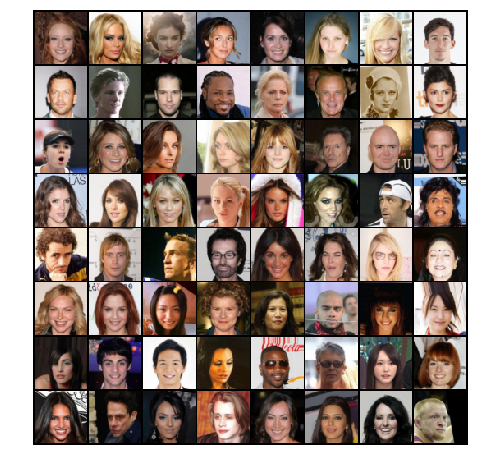

In [14]:
show_real_batch(data_loader, figsize=(8, 8))

In [15]:
crit = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=DEVICE)
real_label = 1
fake_label = 0

In [17]:
class GenBlock(nn.Module):

    def __init__(self, ni, no, kernel, stride, pad, bias=False):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, kernel, stride, pad, bias=bias)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [18]:
class Generator(nn.Module):

    def __init__(self, nz, nf, nc):
        super().__init__()
        self.main = nn.Sequential(
            GenBlock(nz,     nf * 8, 4, 1, 0),
            GenBlock(nf * 8, nf * 4, 4, 2, 1),
            GenBlock(nf * 4, nf * 2, 4, 2, 1),
            GenBlock(nf * 2, nf,     4, 2, 1),
            nn.ConvTranspose2d(nf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.apply(init_weights)

    def forward(self, x):
        return self.main(x)

In [19]:
class ConvBlock(nn.Module):

    def __init__(self, ni, no, kernel, stride, pad, alpha=0.2, bias=False):
        super().__init__()
        self.conv = nn.Conv2d(ni, no, kernel, stride, pad, bias=bias)
        self.bn = nn.BatchNorm2d(no)
        self.leaky_relu = nn.LeakyReLU(alpha, True)

    def forward(self, x):
        return self.leaky_relu(self.bn(self.conv(x)))

In [20]:
class Discriminator(nn.Module):

    def __init__(self, nf, nc):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, nf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            ConvBlock(nf,     nf * 2, 4, 2, 1),
            ConvBlock(nf * 2, nf * 4, 4, 2, 1),
            ConvBlock(nf * 4, nf * 8, 4, 2, 1),
            nn.Conv2d(nf * 8, 1,      4, 1, 0),
            nn.Sigmoid()
        )
        self.apply(init_weights)

    def forward(self, x):
        return self.main(x)

In [21]:
def init_weights(m):
    class_name = m.__class__.__name__
    if class_name in ('ConvBlock', 'GenBlock'):
        for child in m.children():
            init_weights(child)
    elif class_name.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif class_name.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [22]:
g = Generator(nz, n_gen_feat, nc).to(DEVICE)
d = Discriminator(n_dis_feat, nc).to(DEVICE)

In [ ]:
opt_g = optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.999))
opt_d = optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
g_losses, d_losses = [], []
img_list = []
iters = 0

In [ ]:
print('Starting training loop...')
for epoch in range(epochs):
    for i, (real, _) in enumerate(data_loader):
        
        # run discriminator against batch of real data
        d.zero_grad()
        size = real.size(0)
        label = torch.full((size,), real_label, device=DEVICE)
        output = d(real).view(-1)
        err_d_real = crit(output, label)
        err_d_real.backward()
        d_x = output.mean().item()
        
        # run discriminator against fakes generated from noise vector
        noise = torch.randn(size, nz, 1, 1, device=DEVICE)
        fake = g(noise)
        label.fill_(fake_label)
        output = d(fake.detach()).view(-1)
        err_d_fake = crit(output, label)
        err_d_fake.backward()
        d_g_z1 = output.mean().item()
        
        # updating discriminator parameters
        err_d = err_d_real + err_d_fake
        opt_d.step()
        
        # updating generator based on how many images "tricked" the generator 
        g.zero_grad()
        label.fill_(real_label)
        output = d(fake).view(-1)
        err_g = crit(output, label)
        err_g.backward()
        d_g_z2 = output.mean().item()
        opt_g.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\t'
                  'Loss_D: %.4f\t'
                  'Loss_G: %.4f\t'
                  'D(x): %.4f\t'
                  'D(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(data_loader),
                     err_d.item(), err_g.item(), d_x, d_g_z1, d_g_z2))

        